In [1]:
from google.colab import files
files.upload() # kaggle.jsonをアップロード
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


  0% 0.00/463k [00:00<?, ?B/s]
100% 463k/463k [00:00<00:00, 59.1MB/s]
Archive:  travel-insurance.zip
  inflating: travel insurance.csv    
      Agency    Agency Type  ... Gender Age
0        CBH  Travel Agency  ...      F  81
1        CBH  Travel Agency  ...      F  71
2        CWT  Travel Agency  ...    NaN  32
3        CWT  Travel Agency  ...    NaN  32
4        CWT  Travel Agency  ...    NaN  41
...      ...            ...  ...    ...  ..
63321    JZI       Airlines  ...      M  31
63322    JZI       Airlines  ...      F  40
63323    JZI       Airlines  ...      M  57
63324    JZI       Airlines  ...      M  63
63325    JZI       Airlines  ...      F  35

[63326 rows x 11 columns]
Num of Features 5


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


---Without entity embedding---
              precision    recall  f1-score   support

          No       0.64      0.72      0.68        94
         Yes       0.68      0.60      0.64        94

    accuracy                           0.66       188
   macro avg       0.66      0.66      0.66       188
weighted avg       0.66      0.66      0.66       188

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in1 (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
in2 (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
in3 (InputLayer)               

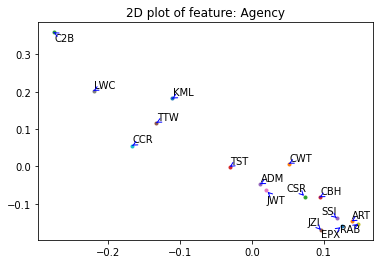

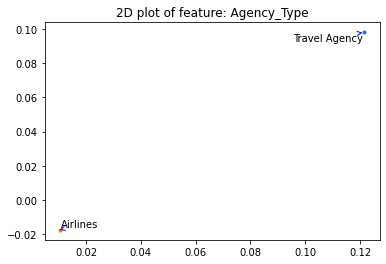

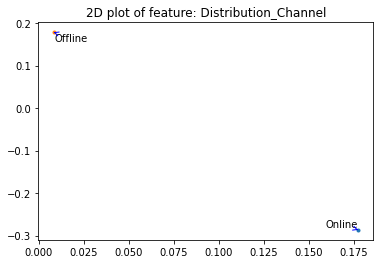

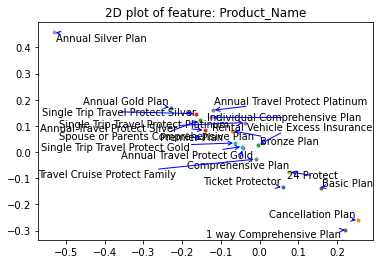

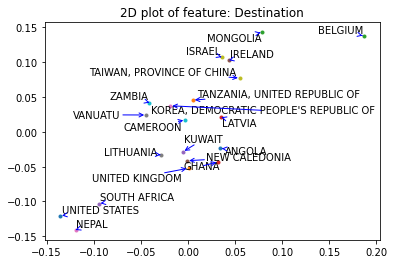

In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# ニューラルネットワークの構築のためにインポート
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input, Flatten
from tensorflow.keras.layers import Activation, Reshape
from tensorflow.keras.layers import Dense, Concatenate, Dropout
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam
# 可視化用にインポート
import matplotlib.pyplot as plt
%matplotlib inline
# 散布図のテキストラベル位置調整のため
!pip3 install adjustText
from adjustText import adjust_text
# ラベルエンコーディングのためにインストール
!pip install category_encoders
# category_encodersをインポート
import category_encoders as cate_enc
import collections as colle

# データの準備
def prepare():
    !kaggle datasets download -d mhdzahier/travel-insurance
    !unzip travel-insurance.zip

# エンティティ埋め込みクラス
class EntityEmbedder:
    def __init__(self, input_dims, emb_dims, output_dim):
        # 各特徴量の入力次元数
        self.dims = input_dims
        # 各特徴量の埋め込み次元数
        self.embdims = emb_dims
        # 出力次元数（ラベルの種類数）
        self.output_dim = output_dim
        self.dropout_rate = 0.2
        self.activation = 'relu'
        self.optimizer = 'Adam'
        self.loss = 'binary_crossentropy'
        self.weights = None
        self.buildEmbModel()
        
    # モデルの構築(ラベルエンコーディング後のデータを入力）
    def buildEmbModel(self):
        inputs, embeds = [], []
        for i, (input_dim, emb_dim) in \
                 enumerate(zip(self.dims, self.embdims)):
            input_c = Input(shape=(1,), \
                            name='in{}'.format(i+1))
            # 埋め込み(Embedding)層の定義
            embed = Embedding(input_dim=input_dim, 
                              output_dim=emb_dim, 
                              input_length=None, 
                       name='emb{}'.format(i+1))(input_c)
            output = Reshape(\
                           target_shape=(emb_dim,))(embed)
            inputs.append(input_c) 
            embeds.append(output)
        # 埋め込み層の出力を連結する
        out = Concatenate(name='conc_layer', \
                          axis=-1)(embeds) 
        out = Dropout(self.dropout_rate)(out) 
        # 隠れ層のユニット数
        hd = [8]
        for n in range(len(hd)): 
            out = Dense(hd[n])(out) 
        out = Activation(self.activation)(out)
        out = Dense(self.output_dim)(out)
        out = Activation('softmax')(out)
        self.model = Model(inputs=inputs, outputs=out)
        self.model.compile(optimizer=self.optimizer, 
                         loss=self.loss,
                        metrics=['accuracy'])
        self.model.summary()

    # 学習を行うメソッド（入力ベクトルは特徴量の数だけある）
    def fit(self, X, y, epochs=30, shuffle=True, batch_size=5):
        self.model.fit( X, y, \
            epochs = epochs, shuffle=shuffle, \
            batch_size=batch_size, verbose=1)
        # 学習済みネットワークの重みを格納
        self.weights = self.model.get_weights()
        # 埋め込み層の出力を連結したベクトルを取得するための
        # メソッドを定義する
        inputs = [self.model.get_layer('in%d' % \
                 (i+1)).input for i \
                 in range(len(self.dims))] 
        # 埋め込み層からの出力を連結する層の出力を取得
        self.get_hidden_out = \
          Model(inputs=self.model.inputs, \
          outputs=\
          self.model.get_layer('conc_layer').output)

    # 順序エンコーディングベクトルovから
    # エンティティ埋め込みベクトルを取得して返す
    def get_vector(self, ov):
        vec = self.get_hidden_out(ov)
        return vec

    # 特徴量（列）番号(fid)とカテゴリーID(cid)を渡すと、
    # そのカテゴリの特徴量ベクトルを返す
    def get_embedding(self, fid, cid):
        emb = self.weights[fid][cid, :]
        return emb

# クラスごとのデータ数をそろえる
def resampling(newX, y, lim, labels):
    fc = [0] * len(labels)
    nX, nY = [], []
    for i in range(len(y)):
        if fc[y[i]] == lim:
            continue
        fc[y[i]] += 1
        nX.append(newX[i])
        nY.append(y[i])
    return nX, nY

# 前処理
# データフレームの作成、クラスの偏りを修正
def preprocess():
    # 旅行者のクレームの有無のデータ
    df = pd.read_csv('travel insurance.csv', encoding='utf-8')
    print(df)
    features = ['Agency','Agency Type', 'Distribution Channel', 
                'Product Name', 'Destination']
    labels = [0,1]
    target_names=['No', 'Yes']
    df['Claim'].replace({'Yes':1, 'No':0}, inplace=True)
    # データの少ないクラスに合わせるため、
    # 各クラスのうち少数派クラスのデータ数をlimに格納
    y_bool = df['Claim'] == 1
    n_bool = df['Claim'] == 0
    lim = y_bool.sum()
    if y_bool.sum() > n_bool.sum():
        lim = n_bool.sum()
    y = df['Claim'].values
    df.drop('Claim', axis=1, inplace=True)
    df = pd.DataFrame(df, columns=features)
    df.fillna('N')
    n_features = len(df.columns)
    print('Num of Features {}'.format(n_features))
    return df, y, lim, labels, features, target_names

# ラベルエンコーディング
def ordinal_encoding(df, features, lim, y, labels, encoder):
    input_dims = []
    newX = np.array([])
    # ラベルエンコーディングのクラスインスタンスを生成
    if encoder == None:
        encoder = cate_enc.OrdinalEncoder(cols=features, \
           handle_unknown='value', handle_missing='value')
        df_enc = encoder.fit_transform(df)
    else:
        df_enc = encoder.fit_transform(df)
    newX = df_enc.values
    dl = {}
    for i in range(len(newX)):
        n = 0
        for j in range(len(newX[i])):
            if not n in dl:
                dl[n] = []
            dl[n].append(newX[i][j])
            n+=1
    for n,v in dl.items():
        cnt = colle.Counter(v)
        mc = cnt.most_common()
        kinds = len(mc)
        input_dims.append(kinds)
    # クラスの偏りを無くすために少数派クラスの
    # 件数limに揃える
    nX, nY = resampling(newX, y, lim, labels)
    # カテゴリのIDを0から開始するように変換する
    nX = np.array(nX)
    nX = np.reshape(nX, (len(nX), len(nX[0]),))
    nY = np.array(nY)
    nY = np.reshape(nY, (len(nY), 1, ))
    nX = np.asarray(list(map(lambda x: x-1, nX)))
    return nX, nY, input_dims, encoder

def conv_form(X, input_dims):
    nX = []
    for i,id in enumerate(input_dims):
        x = np.asarray(X[:,i], dtype=np.int32)
        x = np.asarray([j for j in x],\
                    dtype=np.int32).reshape((len(x),1))
        nX.append(x)
    return nX

# エンティティ埋め込みの学習
def convertByEntityEmbedding(X_train, y_train, \
              X_test, y_test, labels, input_dims):
    y_train = to_categorical(y_train, num_classes=len(labels))
    X_train = np.array(X_train)
    X_train = conv_form(X_train, input_dims)
    y_test = to_categorical(y_test, num_classes=len(labels))
    X_test = np.array(X_test)
    X_test = conv_form(X_test, input_dims)

    # 埋め込みベクトルの次元数を2に設定する
    emb_dims = []
    for id in input_dims:
        emb_dims.append(2)
    output_dim = len(labels)
    ee = EntityEmbedder(input_dims, emb_dims, output_dim)
    # epochs = 7 で学習
    ee.fit(X_train, y_train, epochs=7)
    # 学習したモデルから、埋め込みベクトルを取得する
    x_trainvect = ee.get_vector(X_train)
    x_testvect = ee.get_vector(X_test)
    return x_trainvect, x_testvect, y_train, y_test, ee

# SVMによる評価(エンティティ埋め込み有り)
def predict_by_SVM(x_trainvect, x_testvect, \
                   y_train, y_test, target_names):
    y_train_new, y_test_new = [], []
    i = 0
    for yf in y_train:
        y_train_new.append(np.argmax(yf))
    for yf in y_test:
        y_test_new.append(np.argmax(yf))
    svm = SVC()
    svm.fit(x_trainvect, y_train_new)
    y_pred = svm.predict(x_testvect)
    print('---With entity embedding---')
    print(classification_report(y_test_new, y_pred,target_names=target_names))

# SVMによる評価(エンティティ埋め込み無し)
def predict_by_SVM_withoutEE(X_train, X_test, \
                        y_train, y_test, target_names):
    y_train_new, y_test_new = [], []
    X_train = np.reshape(X_train, (len(X_train),\
                         len(X_train[0])))
    y_train = np.reshape(y_train, (len(y_train) ))
    X_test = np.reshape(X_test, (len(X_test), len(X_test[0])))
    y_test = np.reshape(y_test, (len(y_test) ))
    svm = SVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    print('---Without entity embedding---')
    print(classification_report(y_test, y_pred,\
                       target_names=target_names))

# エンティティ埋め込み結果を可視化
def makeGraph(data, texts, cate):
    if len(data) > 20:
        p = np.random.permutation(len(data))
        data = data[p[:20]]
        texts = texts[p[:20]]
    for (dim1,dim2,label) in zip(data[:,0], data[:,1], texts):
        plt.plot(dim1, dim2, '.' )
    ptxt = [plt.text(x, y, lb, ha='center', va='center') \
            for x,y,lb in zip(data[:,0], data[:,1], texts)]
    adjust_text(ptxt, arrowprops=dict(arrowstyle='->',\
                                      color='blue'))
    cate = re.sub(r'\s+', '_', cate)
    plt.title('2D plot of feature: {}'.format(cate))
    plt.savefig('./data-fig_{}.png'.format(cate), dpi=400)
    plt.show()
def main():
    prepare()
    df, y, lim, labels, features, target_names = preprocess()
    # ラベルエンコーディングしたベクトル形式に変換
    X_train, X_test, y_train, y_test = \
      train_test_split(df.loc[:,features].values, \
                       y, train_size=0.9, random_state=10)
    df_train = pd.DataFrame(X_train, columns=features)
    cc = [0, 0]
    for yv in y_train:
        cc[yv] += 1
    lim_train = np.min(cc)
    X_train, y_train, input_dims_train, enc = \
        ordinal_encoding(df_train, features, lim_train,\
                         y_train, labels, None)
    df_test = pd.DataFrame(X_test, columns=features)
    cc = [0, 0]
    for yv in y_test:
        cc[yv] += 1
    lim_test = np.min(cc)
    X_test, y_test, input_dims, _ = \
       ordinal_encoding(df_test, features, \
                        lim_test, y_test, labels, enc)
    
    # エンティティ埋め込み無しで、SVMによる予測
    predict_by_SVM_withoutEE(X_train, X_test, \
                             y_train, y_test, target_names)
    # カテゴリ特徴量をラベルエンコーディングしたデータを
    # エンティティ埋め込みベクトルに変換するために
    # 教師あり学習を行い、エンティティ埋め込みベクトルを取得
    x_trainvect, x_testvect, y_train, y_test, ee = \
        convertByEntityEmbedding(X_train, y_train, \
                  X_test, y_test, labels, input_dims_train)
    # SVMで学習・予測結果の評価
    predict_by_SVM(x_trainvect, x_testvect,
                   y_train, y_test, target_names)
    # 各カテゴリの埋め込みベクトルを可視化する
    for i in range(len(features)):
        veclist, texts = [], []
        obm = enc.mapping[i]['mapping']
        for idx, kv in zip(obm.index, obm):
            if kv < 0:
                continue
            embv = ee.get_embedding(i, kv-1)
            veclist.append(embv)
            texts.append(idx)
        veclist = np.asarray(veclist, dtype=np.float32)
        texts = np.asarray(texts)
        makeGraph(veclist, texts, features[i])

if __name__ == '__main__':
    main()
    